In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split

import sys

import shap


/opt/homebrew/anaconda3/envs/Ariel/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# open hdf5
path = "../DATA/contribution_22_full.hdf5"
ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 329MB
Dimensions:                 (wavelength: 52, sample: 91392, parameter: 6,
                             quartile: 3, species: 5)
Coordinates:
  * wavelength              (wavelength) float64 416B 0.55 0.7 ... 6.814 7.276
  * sample                  (sample) int64 731kB 0 1 2 3 ... 91389 91390 91391
  * parameter               (parameter) <U13 312B 'planet_temp_k' ... 'log_NH3'
  * quartile                (quartile) <U2 24B 'q1' 'q2' 'q3'
  * species                 (species) <U3 60B 'H2O' 'CO2' 'CH4' 'CO' 'NH3'
Data variables: (12/22)
    bin_width               (wavelength) float64 416B ...
    spectrum                (sample, wavelength) float64 38MB ...
    noise                   (sample, wavelength) float64 38MB ...
    planet_temp_k           (sample) float64 731kB ...
    log_H2O                 (sample) float64 731kB ...
    log_CO2                 (sample) float64 731kB ...
    ...                      ...
    planet_radius_m         (sample) float64 731kB ...
    planet_surface_gravity  (sample) float64 731kB ...
    valid_quartiles         (sample) bool 91kB ...
    parameter_quartiles     (sample, parameter, quartile) float64 13MB ...
    contributions           (sample, species, wavelength) float64 190MB ...
    clean_forward_model     (sample, wavelength) float64 38MB ...

In [3]:
ipath = "../DATA/train_validation_indecies.hdf5"
ids = xr.open_dataset(ipath)
ids

<xarray.Dataset> Size: 731kB
Dimensions:    (train_samples: 73113, val_samples: 18279)
Dimensions without coordinates: train_samples, val_samples
Data variables:
    train_idx  (train_samples) int64 585kB ...
    val_idx    (val_samples) int64 146kB ...

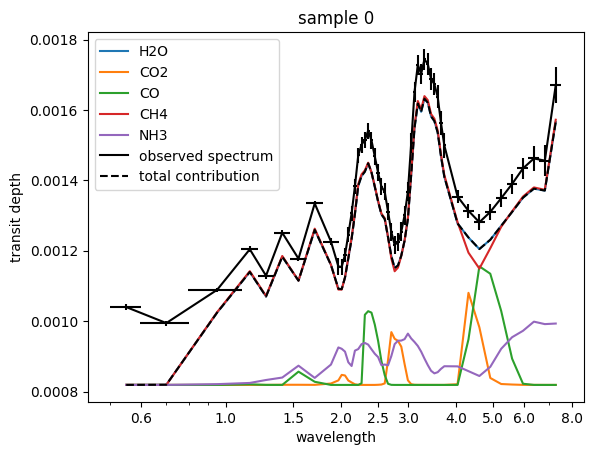

In [4]:
i = 0
all_species = ds.species.values[1:]

plt.plot(
    ds['wavelength'],
ds['contributions'].sel(sample=i,
                    species=['H2O', 'CO2', 'CO', 'CH4', 'NH3']
                    ).values.T, label=['H2O', 'CO2', 'CO', 'CH4', 'NH3'])

plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()

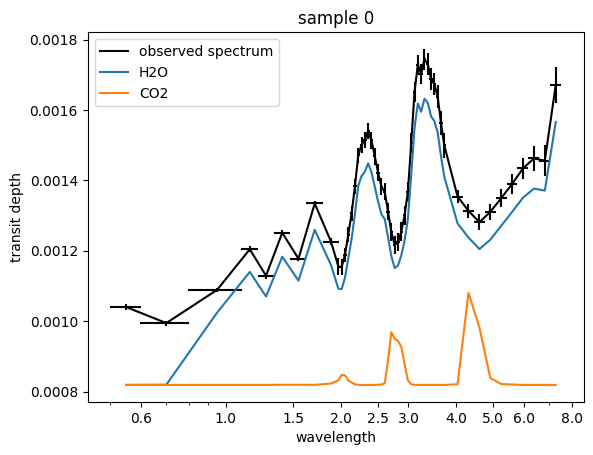

In [5]:
i = 0


# plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['H2O']).values.T, label='H2O')

plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

plt.plot(
    ds['wavelength'],
ds['contributions'].sel(sample=i,
                    species=['H2O', 'CO2']
                    ).values.T, label=['H2O', 'CO2',])

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()

In [6]:
label_names = ['log_H2O', 'log_CO2']
labels = ds[label_names]
labels_np = labels.to_array().values.T

labels_np.shape

(91392, 2)

In [7]:
spectrum_np = ds['spectrum'].values
spectrum_np.shape

(91392, 52)

In [8]:
noise_np = ds['noise'].values
h2o_np = ds['contributions'].sel(species='H2O').values
co2_np = ds['contributions'].sel(species='CO2').values
noise_np.shape

(91392, 52)

In [9]:
train_spectra = spectrum_np[ids['train_idx']]
train_labels = labels_np[ids['train_idx']]
train_noise = noise_np[ids['train_idx']]
train_h2o = h2o_np[ids['train_idx']]
train_co2 = co2_np[ids['train_idx']]
train_spectra.shape, train_labels.shape, train_noise.shape, train_h2o.shape, train_co2.shape

((73113, 52), (73113, 2), (73113, 52), (73113, 52), (73113, 52))

In [10]:
# validation_spectra = spectrum_np[ids['val_idx']]
# validation_labels = labels_np[ids['val_idx']]
# validation_noise = noise_np[ids['val_idx']]
# validation_spectra.shape, validation_labels.shape, validation_noise.shape

In [11]:
# split train into train and test
train_spectra, test_spectra, train_labels, test_labels, train_noise, test_noise, train_h2o, test_h2o, train_co2, test_co2 = train_test_split(train_spectra, train_labels, train_noise, train_h2o, train_co2, test_size=0.2, random_state=42)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}
train_noise: {train_noise.shape}
train_h2o: {train_h2o.shape}
train_co2: {train_co2.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
test_noise: {test_noise.shape}
test_h2o: {test_h2o.shape}
test_co2: {test_co2.shape}
""")


train_spectra: (58490, 52)
train_labels: (58490, 2)
train_noise: (58490, 52)
train_h2o: (58490, 52)
train_co2: (58490, 52)

test_spectra: (14623, 52)
test_labels: (14623, 2)
test_noise: (14623, 52)
test_h2o: (14623, 52)
test_co2: (14623, 52)



In [12]:
class z_normaliser():
    def __init__(self):
        self.mean = None
        self.std = None
    
        
    def normalise(self, data, set=False):
        if set:
            self.mean = np.mean(data, axis=0)
            self.std = np.std(data, axis=0)

        return (data - self.mean) / self.std
    
    def denormalise(self, data):  
        return data * self.std + self.mean
        


In [13]:
class minmax_normaliser():
    def __init__(self):
        self.min = None
        self.max = None
    
        
    def normalise(self, data, set=False):
        if set:
            self.min = np.min(data, axis=0)
            self.max = np.max(data, axis=0)

        return (data - self.min) / (self.max - self.min)
    
    def denormalise(self, data):  
        return data * (self.max - self.min) + self.min
        

In [14]:
class log_normaliser():
    def __init__(self):
        self.min = None  # Stores the min of log-transformed data
        self.max = None  # Stores the max of log-transformed data
    
    def normalise(self, data, set=False):
        data_log = np.log(np.abs(data) + np.finfo(float).eps)
        if set:
            self.min = np.min(data_log, axis=0)
            self.max = np.max(data_log, axis=0)
        return (data_log - self.min) / (self.max - self.min)
    
    def denormalise(self, data):
        data_log = data * (self.max - self.min) + self.min
        return np.exp(data_log) - np.finfo(float).eps

In [15]:
normaliser_class = minmax_normaliser
spectra_normaliser_class = log_normaliser

In [16]:
labels_normaliser = normaliser_class() # contains negative values
spectra_normaliser = spectra_normaliser_class() # can't deal with negative values

train_labels_normalised = labels_normaliser.normalise(train_labels, set=True)
train_spectra_normalised = spectra_normaliser.normalise(train_spectra, set=True)

test_labels_normalised = labels_normaliser.normalise(test_labels)
test_spectra_normalised = spectra_normaliser.normalise(test_spectra)


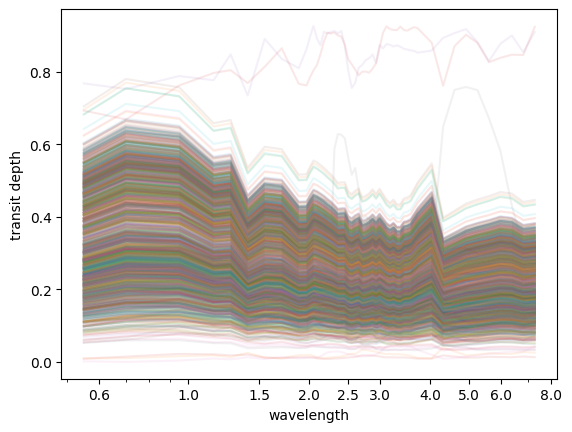

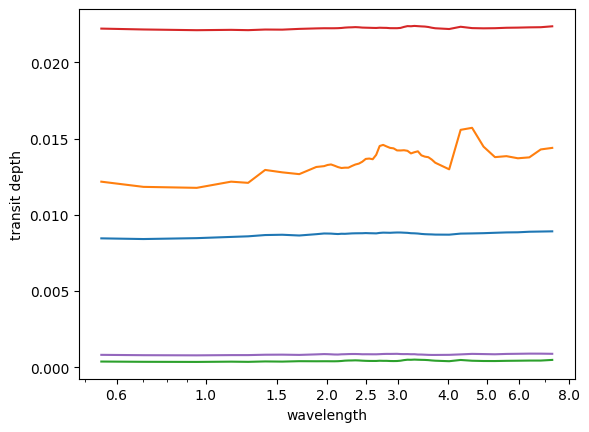

In [17]:
plt.plot(  ds['wavelength'] ,train_spectra_normalised[:2000, :].T,label='mean', alpha=0.1)

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

plt.plot(  ds['wavelength'] ,train_spectra[:5, :].T,label='std')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

In [18]:
def plot_loss(losses, test_losses, epoch):

    losses = np.array(losses)
    test_losses = np.array(test_losses)

    plt.figure()
    plt.plot(losses, "k-", label='train loss')
    plt.plot(test_losses, "g-", label='test loss')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')
    plt.legend()

    plt.ylim(test_losses.mean() - 3 * test_losses.std(), (x if (x := test_losses.mean() + 3 * test_losses.std()) < 4 else 4))

    plt.savefig('training_loss.png')
    plt.close()

In [19]:
def plot_predictions(predictions, labels, epoch):
    # make sure plot is square
    fig, ax = plt.subplots(1,2, figsize=(10,5))

    ax = ax.ravel()
    
    for i in range(2):
        ax[i].plot(labels[:,i], predictions[:,i], "k.")

        corners = [labels[:,i].min(), labels[:,i].max()]
        ax[i].plot(corners, corners, "r--")

        ax[i].set_xlabel(f'true {label_names[i]} value')
        ax[i].set_ylabel(f'predicted {label_names[i]} value')
        ax[i].set_xlim(labels[:,i].min(), labels[:,i].max())
        ax[i].set_ylim(labels[:,i].min(), labels[:,i].max())

    fig.suptitle(f'predictions\nepoch: {epoch}')

    fig.savefig('predictions.png')
    plt.close()

In [20]:
# create a model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [21]:
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()

        self.fc1 = nn.Linear(52, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [22]:
class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()

        chn = 8
        knl = 16
        stride = 1
        pad = knl // 2 # Compute padding for each conv layer: padding = kernel_size // 2

        self.conv_1 = torch.nn.Conv1d(
            in_channels=1, out_channels=chn,
            kernel_size=knl, stride=stride, padding=pad
        )

        self.first_linear_dim = self._get_flatten_dim((1, 52))

        self.fc1 = nn.Linear(self.first_linear_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def _get_flatten_dim(self, input_shape):
        # Create a dummy input tensor with batch size 1
        # input_shape should be (channels, length), here (1, 52)
        x = torch.zeros(1, *input_shape)
        x = torch.nn.LeakyReLU()(self.conv_1(x))

        # print(x.shape)
        # print(x.numel())

        return x.numel()  # total number of elements

    def forward(self, x):
        # print(f'IN: {x.shape}')

        # Add a dummy dimension for the channel
        x = x.unsqueeze(1)
        # print(f'A: {x.shape}')

        x = torch.nn.LeakyReLU()(self.conv_1(x))
        # print(f'B: {x.shape}')

        x = x.view(-1, self.first_linear_dim)
        # print(f'C: {x.shape}')

        x = torch.relu(self.fc1(x))
        # print(f'D: {x.shape}')
        x = torch.relu(self.fc2(x))
        # print(f'E: {x.shape}')
        x = self.fc3(x)
        return x
    

In [23]:
model = NetA()

# create a loss function
criterion = nn.MSELoss()

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) #lr=0.0005)

# create a data loader
batch_size = 128
train_dataset = TensorDataset(torch.Tensor(train_spectra_normalised), torch.Tensor(train_labels_normalised))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
burn_in = 50
patience = 50
threshold = 0.5 #%

train = False

In [25]:
if train:

    batch_losses = []
    epoch_train_losses = []
    epoch_test_losses = []
    delta_t = []
    best_test_loss = np.inf
    epochs_no_improvement = 0


    # train the model
    model.train()
    for epoch in range(1000):
        t = datetime.now()
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        with torch.no_grad():
            test_outputs = model(torch.Tensor(test_spectra_normalised))
            test_loss = criterion(test_outputs, torch.Tensor(test_labels_normalised))

        epoch_test_losses.append(test_loss.item())
        epoch_train_losses.append(np.mean(batch_losses))
        batch_losses = []

        if epoch % 5 == 0:
            plot_loss(epoch_train_losses,epoch_test_losses, epoch)
            unnormed_outputs = labels_normaliser.denormalise(outputs.detach().numpy())
            unnormed_labels = labels_normaliser.denormalise(labels.detach().numpy())
            plot_predictions(unnormed_outputs, unnormed_labels, epoch)

        # if epoch % 10 == 0:
        print(
            f"\repoch: {epoch}, train loss: {epoch_train_losses[epoch]:.5f}, test loss: {epoch_test_losses[epoch]:.5f} ({np.abs(x:=(((epoch_test_losses[epoch]/best_test_loss)*100)-100)):.2f}% {"worse " if x > 0 else "better"} that best), Time per epoch: {np.mean(delta_t):.2f}s"
            ,end=""
            )
        sys.stdout.flush()
        delta_t.append((datetime.now() - t).total_seconds())


        # save the current best model
        if epoch_test_losses[-1] < best_test_loss*(1-threshold/100):
            torch.save(model.state_dict(), f'modela.pt')
            best_test_loss = epoch_test_losses[-1]
            epochs_no_improvement = 0
        elif epoch > burn_in:
            epochs_no_improvement += 1

        # early stopping
        if epochs_no_improvement > patience:
            print(f"\n\nearly stopping at epoch {epoch}, best test loss: {best_test_loss}")
            break



In [26]:
# load the best model 
model.load_state_dict(torch.load('modela.pt'))

<All keys matched successfully>

In [27]:
# make predictions
model.eval()

with torch.no_grad():
    predictions = model(torch.Tensor(test_spectra_normalised))

predictions = labels_normaliser.denormalise(predictions.numpy())

print(f'len(predictions): {predictions.shape}')
print(f'len(test_labels): {test_labels.shape}')

# plot predictions
plot_predictions(predictions, test_labels, 0)

len(predictions): (14623, 2)
len(test_labels): (14623, 2)


## SHAP!

In [28]:
# --- Model Interpretability with SHAP ---
# Set the model to evaluation mode
model.eval()

# Prepare background data: use the first 100 samples of your training data
background = torch.Tensor(train_spectra_normalised[:100])

# Create a SHAP DeepExplainer with the model and background data
explainer = shap.DeepExplainer(model, background)

In [29]:
# Convert your test data to a tensor (if not already)
test_data_tensor = torch.Tensor(test_spectra_normalised)

In [30]:
# Compute SHAP values for the test data
# Note: For models with multiple outputs, shap_values will be a list (one per output)
shap_values = explainer.shap_values(test_data_tensor, check_additivity=False)

print(f'shap values shape {shap_values.shape}')

shap values shape (14623, 52, 2)


In [31]:
joint_shap_values = np.array(shap_values).sum(axis=2)
print(f'joint shap values shape {joint_shap_values.shape}')

joint shap values shape (14623, 52)


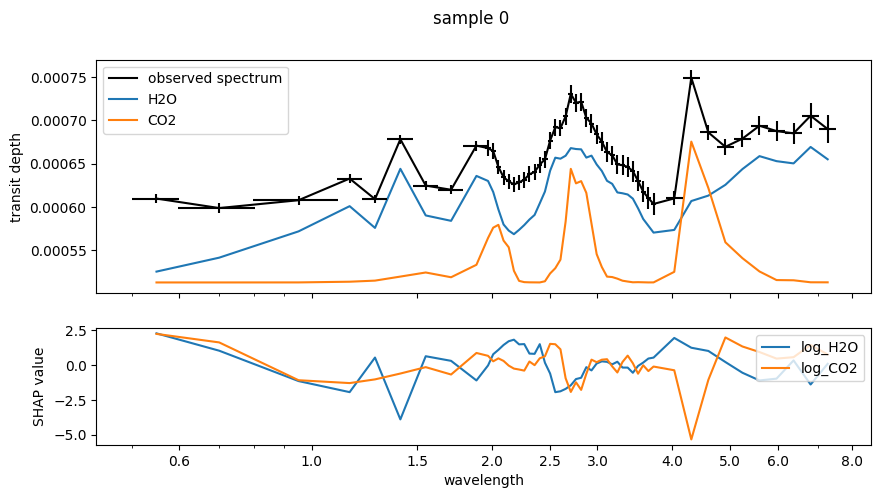

In [32]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_shap = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')
# ax_shap.plot(ds['wavelength'], joint_shap_values[i], 'k-',label='SHAP total')

ax_shap.plot(ds['wavelength'], shap_values[i, :, 0], '-',label=label_names[0])
ax_shap.plot(ds['wavelength'], shap_values[i, :, 1], '-',label=label_names[1])


ax_shap.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_shap.set_ylabel('SHAP value')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i}')
ax_shap.legend(loc='upper right')
ax.legend()

## noise injection

In [33]:
# Assume test_spectra and observation_uncertainty are already defined with shapes (n_samples, 52)
n_samples, n_wavelengths = test_spectra.shape  # n_wavelengths should be 52
n_replicates = 5

# Preallocate the output array with shape:
# (n_samples, 52 (spectrum features), 52 (perturbed wavelength index), 100 (replicates))
noisy_spectra = np.empty((n_samples, n_wavelengths, n_wavelengths, n_replicates))

# Reshape test_spectra for broadcasting to (n_samples, 52, 52, 100)
base_spectra_expanded = np.expand_dims(test_spectra, axis=(2, 3))
base_spectra_expanded = np.tile(base_spectra_expanded, (1, 1, n_wavelengths, n_replicates))

# Generate noise for all perturbations and replicates simultaneously
noise = np.random.normal(
    loc=0.0,
    scale=np.expand_dims(test_noise, axis=(2, 3)),
    size=(n_samples, n_wavelengths, n_wavelengths, n_replicates)
)

# Add noise only to the specific wavelength index being perturbed
perturb_mask = np.eye(n_wavelengths, dtype=bool)[np.newaxis, :, :, np.newaxis]  # Shape (1, 52, 52, 1)
noisy_spectra = base_spectra_expanded + (noise * perturb_mask)

print("Noisy spectra generated with shape:", noisy_spectra.shape)

Noisy spectra generated with shape: (14623, 52, 52, 5)


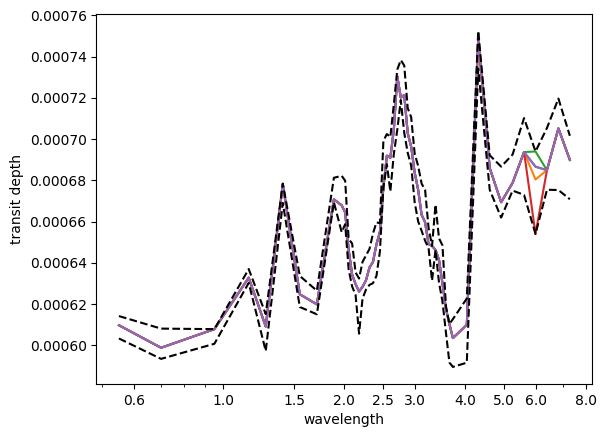

In [34]:
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, 48])
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].min(axis=2).min(axis=1), 'k--',label='min')
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].max(axis=2).max(axis=1), "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

In [35]:
# Convert noisy_spectra to a PyTorch tensor
noisy_spectra_tensor = torch.Tensor(noisy_spectra)  # Shape: (n_samples, 52, 52, 100)

# Reshape to a 2D tensor for batch processing
# New shape: (n_samples * 52 * 100, 52)
n_samples, n_wavelengths, _, n_replicates = noisy_spectra_tensor.shape
noisy_spectra_flat = noisy_spectra_tensor.permute(0, 3, 2, 1).reshape(-1, n_wavelengths)

In [36]:
# Pass through the model
with torch.no_grad():
    predictions_flat = model(noisy_spectra_flat)  # Shape: (n_samples * 52 * 100, 2)

In [37]:
predictions_flat = labels_normaliser.denormalise(predictions_flat)
# Reshape back to the desired shape
# New shape: (n_samples, 2 (labels), 52 (perturbed wavelength), 100 (replicates))
predictions_n = predictions_flat.view(n_samples, n_replicates, n_wavelengths, -1).permute(0, 3, 2, 1)



print("Predictions shape:", predictions_n.shape)  # Should be (n_samples, 2, 52, 100)


Predictions shape: torch.Size([14623, 2, 52, 5])


/var/folders/zh/qc7vldz11_b9qr83pcdjjpk40000gn/T/ipykernel_6869/1402094505.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return data * (self.max - self.min) + self.min


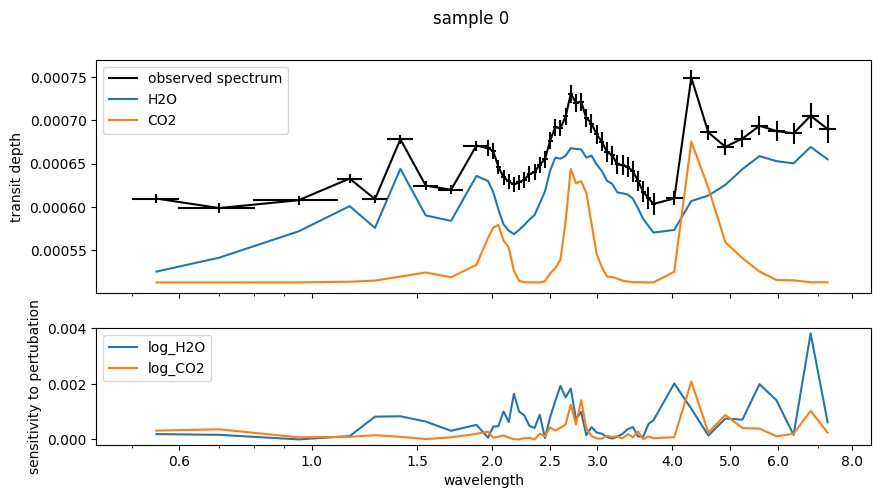

In [38]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_pert = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

ax_pert.plot(  ds['wavelength'] ,predictions_n[i, 0, :].std(axis=1), '-',label=label_names[0])
ax_pert.plot(  ds['wavelength'] ,predictions_n[i, 1, :].std(axis=1), '-',label=label_names[1])


ax_pert.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_pert.set_ylabel('sensitivity to pertubation')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i}')
ax_pert.legend(loc='upper left')
ax.legend()

In [39]:
# make as good as 'ground truth' predictions
model.eval()

with torch.no_grad():
    predictions = model(torch.Tensor(test_spectra_normalised))

predictions = labels_normaliser.denormalise(predictions.numpy())

print(f'len(predictions): {predictions.shape}')
print(f'len(test_labels): {test_labels.shape}')

len(predictions): (14623, 2)
len(test_labels): (14623, 2)


In [40]:
# Compute the mean squared error (MSE) for each perturbation and replicate

# predictions is a NumPy array of shape (n_samples, 2, 52, 100)
# test_labels is a NumPy array of shape (n_samples, 2)

# Broadcast test_labels to match the predictions' shape
# Shape after broadcasting: (n_samples, 2, 52, 100)
labels_broadcasted = np.tile(predictions[:, :, None, None], (1, 1, 52, n_replicates))

# Compute MSE across the label axis (Axis 1)
relative_squared_error = (( predictions_n - labels_broadcasted) / labels_broadcasted)**2 

# mse_array shape: (n_samples, 52, 100)
print("relative_squared_error array shape:", relative_squared_error.shape)



relative_squared_error array shape: torch.Size([14623, 2, 52, 5])


/var/folders/zh/qc7vldz11_b9qr83pcdjjpk40000gn/T/ipykernel_6869/2378678517.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  relative_squared_error = (( predictions_n - labels_broadcasted) / labels_broadcasted)**2


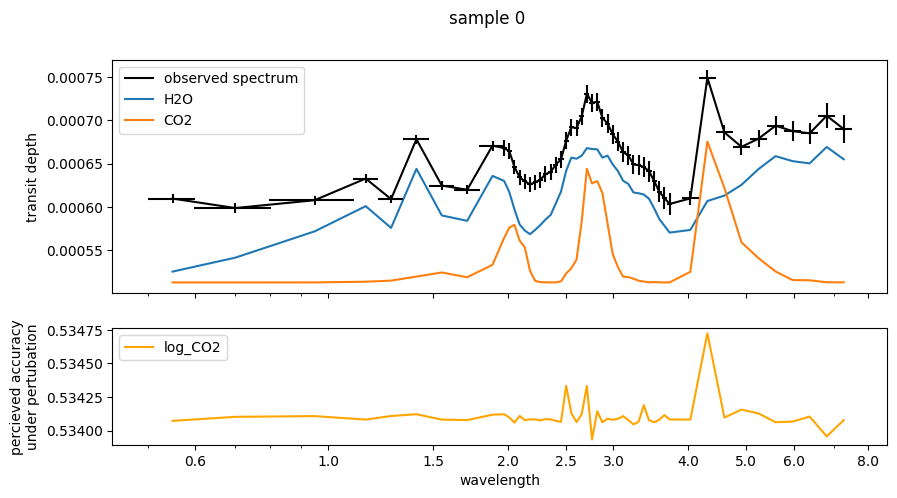

In [51]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_pert = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

# ax_pert.plot(  ds['wavelength'] ,relative_squared_error[i, 0, :].mean(axis=1),label=label_names[0])
ax_pert.plot(  ds['wavelength'] ,relative_squared_error[i, 1, :].mean(axis=1),color = 'orange',label=label_names[1])


ax_pert.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_pert.set_ylabel('percieved accuracy\nunder pertubation')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i}')
ax_pert.legend(loc='upper left')
ax.legend()

In [42]:
# Compute the mean squared error (MSE) for each perturbation and replicate

# predictions is a NumPy array of shape (n_samples, 2, 52, 100)
# test_labels is a NumPy array of shape (n_samples, 2)

# Broadcast test_labels to match the predictions' shape
# Shape after broadcasting: (n_samples, 2, 52, 100)
gt_broadcasted = np.tile(test_labels[:, :, None, None], (1, 1, 52, n_replicates))

# Compute MSE across the label axis (Axis 1)
gt_relative_squared_error = (( predictions_n - gt_broadcasted) / gt_broadcasted)**2 

# mse_array shape: (n_samples, 52, 100)
print("gt_relative_squared_error array shape:", gt_relative_squared_error.shape)



gt_relative_squared_error array shape: torch.Size([14623, 2, 52, 5])


/var/folders/zh/qc7vldz11_b9qr83pcdjjpk40000gn/T/ipykernel_6869/1907651816.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gt_relative_squared_error = (( predictions_n - gt_broadcasted) / gt_broadcasted)**2


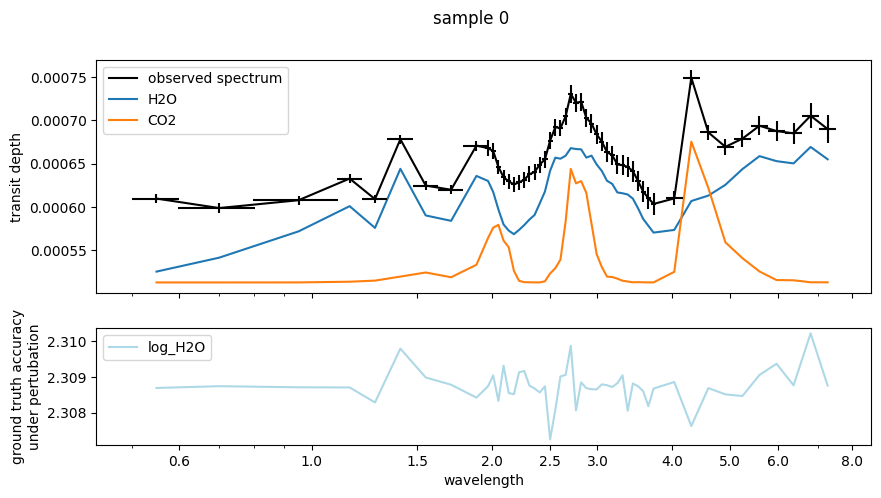

In [52]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_pert = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

ax_pert.plot(  ds['wavelength'] ,gt_relative_squared_error[i, 0, :].mean(axis=1), color='lightblue',label=label_names[0])
# ax_pert.plot(  ds['wavelength'] ,gt_relative_squared_error[i, 1, :].mean(axis=1), color='orange',label=label_names[1])


ax_pert.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_pert.set_ylabel('ground truth accuracy\nunder pertubation')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i}')
ax_pert.legend(loc='upper left')
ax.legend()

## modified noise injection

In [44]:
# Define noise injection hyperparameters
fwhm = 3.0  # full-width at half-maximum; adjust as needed
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

In [45]:
# test_spectra and observation_uncertainty shapes (n_samples, 52)
n_samples, n_wavelengths = test_spectra.shape  # n_wavelengths 52
n_replicates = 10

# Preallocate the output array with shape:
# (n_samples, 52 (spectrum features), 52 (perturbed wavelength index),  n_replicates)
noisy_spectra = np.empty((n_samples, n_wavelengths, n_wavelengths, n_replicates))

# Reshape test_spectra for broadcasting to (n_samples, 52, 52, n_replicates)
base_spectra_expanded = np.expand_dims(test_spectra, axis=(2, 3))
base_spectra_expanded = np.tile(base_spectra_expanded, (1, 1, n_wavelengths, n_replicates))

# Generate noise for all perturbations and replicates simultaneously
noise = np.random.normal(
    loc=0.0,
    scale=np.expand_dims(test_noise, axis=(2, 3)),
    size=(n_samples, n_wavelengths, n_wavelengths, n_replicates)
)

# Create a Gaussian mask of shape (52, 52)
indices = np.arange(n_wavelengths)
gauss_mask = np.exp(-0.5 * ((indices[:, None] - indices[None, :]) / sigma) ** 2)

# Expand dimensions to match noise array shape: (1, 52, 52, 1)
gauss_mask = gauss_mask[np.newaxis, :, :, np.newaxis]

# Add noise using the Gaussian window mask
noisy_spectra = base_spectra_expanded + (noise * gauss_mask)

print("Noisy spectra generated with shape:", noisy_spectra.shape)

Noisy spectra generated with shape: (14623, 52, 52, 10)


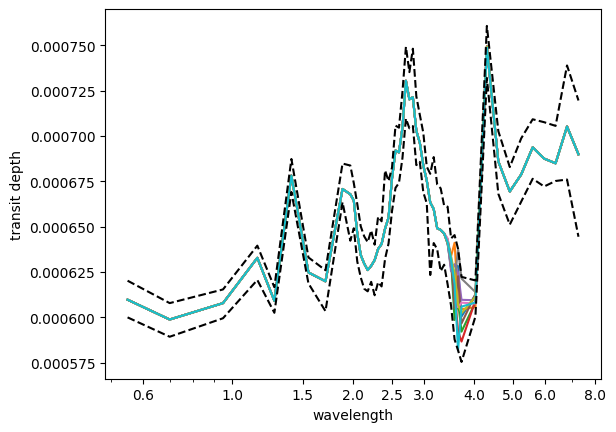

In [46]:
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, 40])
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].min(axis=2).min(axis=1), 'k--',label='min')
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].max(axis=2).max(axis=1), "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

In [47]:
# Convert noisy_spectra to a PyTorch tensor
noisy_spectra_tensor = torch.Tensor(noisy_spectra)  # Shape: (n_samples, 52, 52, 100)

# Reshape to a 2D tensor for batch processing
# New shape: (n_samples * 52 * 100, 52)
n_samples, n_wavelengths, _, n_replicates = noisy_spectra_tensor.shape
noisy_spectra_flat = noisy_spectra_tensor.permute(0, 3, 2, 1).reshape(-1, n_wavelengths)

In [48]:
# Pass through the model
model.eval()

with torch.no_grad():
    predictions_flat = model(noisy_spectra_flat)  # Shape: (n_samples * 52 * 100, 2)

In [49]:
predictions_flat = labels_normaliser.denormalise(predictions_flat)
# Reshape back to the desired shape
# New shape: (n_samples, 2 (labels), 52 (perturbed wavelength), 100 (replicates))
predictions_n = predictions_flat.view(n_samples, n_replicates, n_wavelengths, -1).permute(0, 3, 2, 1)



print("Predictions shape:", predictions_n.shape)  # Should be (n_samples, 2, 52, 100)


Predictions shape: torch.Size([14623, 2, 52, 10])


/var/folders/zh/qc7vldz11_b9qr83pcdjjpk40000gn/T/ipykernel_6869/1402094505.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return data * (self.max - self.min) + self.min


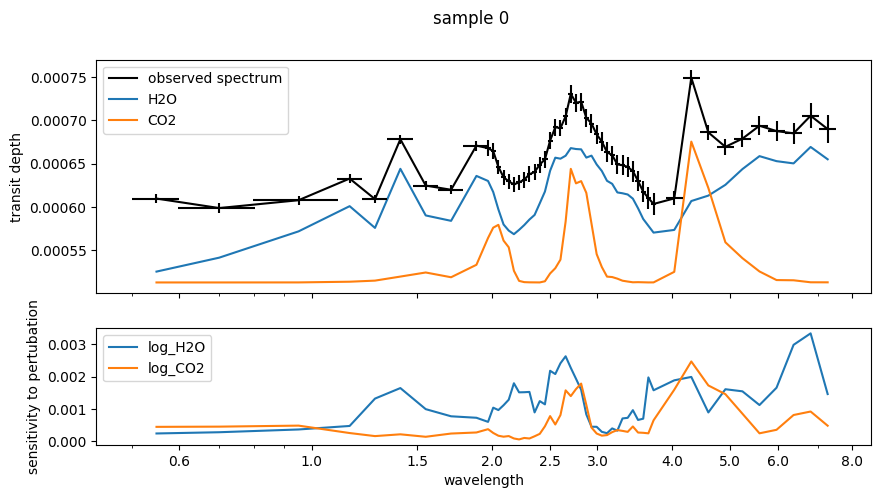

In [53]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_pert = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )

# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

ax_pert.plot(  ds['wavelength'] ,predictions_n[i, 0, :].std(axis=1), '-',label=label_names[0])
ax_pert.plot(  ds['wavelength'] ,predictions_n[i, 1, :].std(axis=1), '-',label=label_names[1])


ax_pert.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_pert.set_ylabel('sensitivity to pertubation')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i}')
ax_pert.legend(loc='upper left')
ax.legend()